In [4]:
import openmm as mm
import openmm.app as app
from Bio.PDB import PDBParser, PDBIO
#
from ipywidgets import Image
#
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)
from openff.toolkit import ForceField, Molecule, Topology
from openff.units import Quantity
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE
from ptm_prototype import draw_molecule
#
import rdkit
from rdkit import Chem
from rdkit import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.rdChemReactions import ReactionFromSmarts
print(rdkit.__version__)
#
import IPython
from rdkit.Chem.rdchem import AtomPDBResidueInfo
#
from openff.pablo import ResidueDefinition
from openff.pablo.chem import PEPTIDE_BOND
#
Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)
draw_options = Chem.Draw.MolDrawOptions()
draw_options.addAtomIndices = True

2025.03.6


In [5]:
parser = PDBParser()
structure = parser.get_structure("9BFX_clean", "9BFX_clean.pdb")
io = PDBIO()
io.set_structure(structure)
io.save("9BFX_clean_biopdb.pdb")

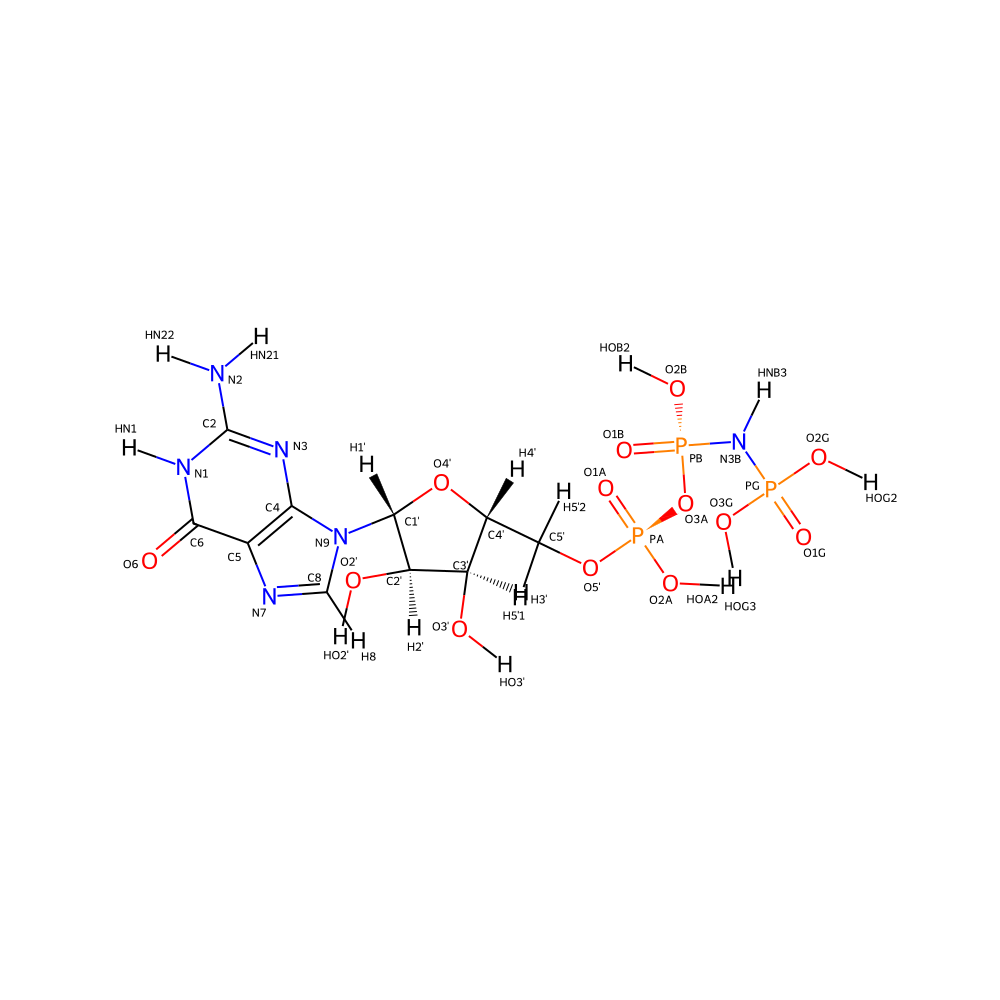

In [6]:
MG_off = CCD_RESIDUE_DEFINITION_CACHE["MG"][0].to_openff_molecule()
#
MG_resdef = ResidueDefinition.from_molecule(
    molecule=MG_off,
    residue_name="MG",
)
#
GNP_off = CCD_RESIDUE_DEFINITION_CACHE["GNP"][0].to_openff_molecule()
#
GNP_resdef = ResidueDefinition.from_molecule(
    molecule=GNP_off,
    residue_name="GNP",
)
#
draw_molecule(
    GNP_off,
    width=1000,
    height=1000,
    atom_notes={
        i: (
            f"{atom.name}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(GNP_off.atoms)
    },
)

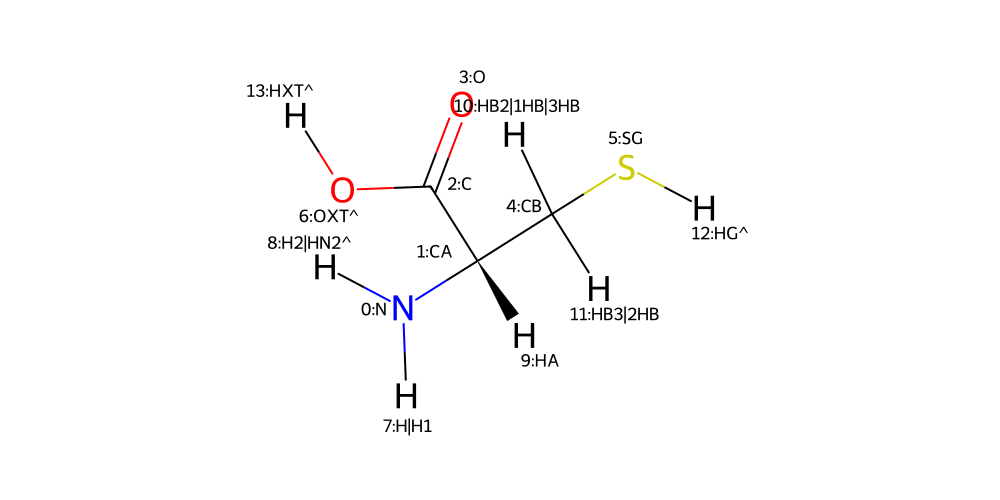

In [7]:
cysteine = CCD_RESIDUE_DEFINITION_CACHE["CYS"][0].to_openff_molecule()
draw_molecule(
    cysteine,
    width=1000,
    height=500,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(cysteine.atoms)
    },
)

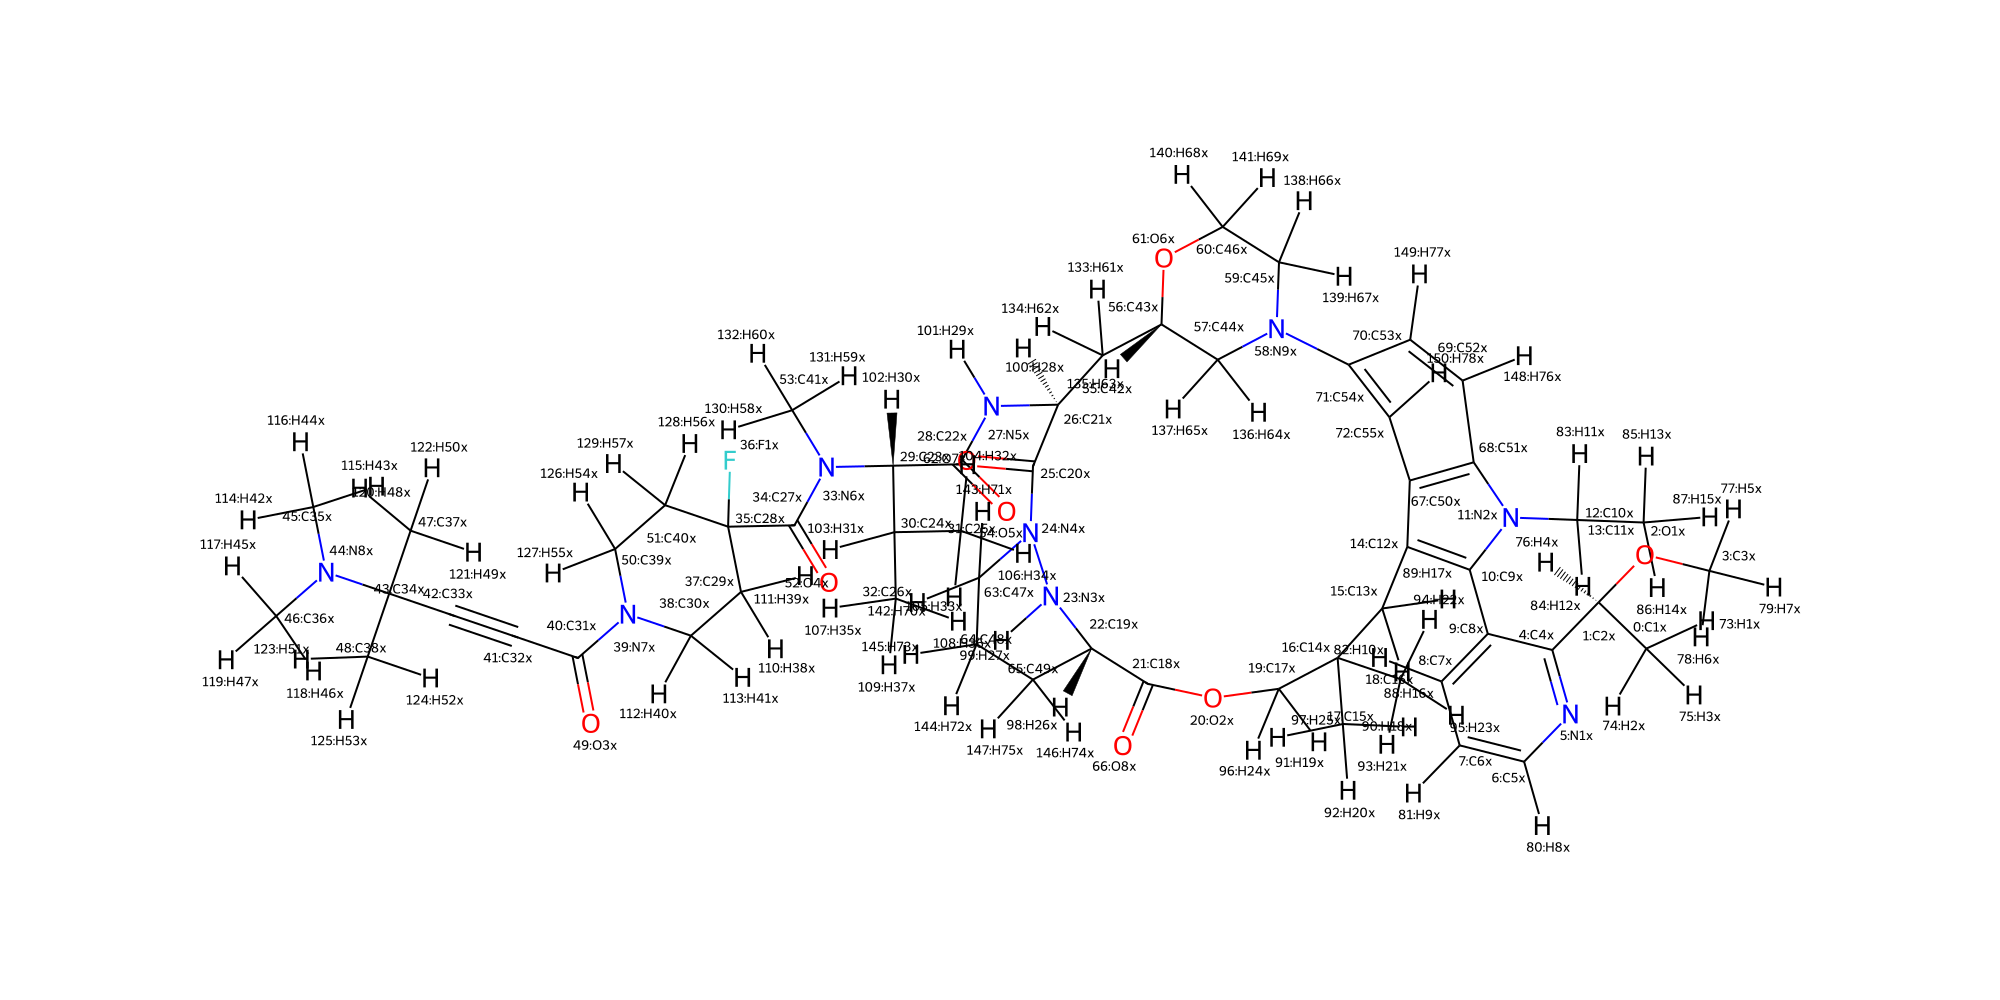

In [8]:
Elironrasib = Molecule.from_smiles("C[C@H](OC)C(N=CC=C1)=[C@@]1[C@](N2CC)=C(CC(C)(C)COC([C@H]3NN(C([C@@H](NC([C@H](C(C)C)N(C(C4(F)CCN(C(C#CC(N(C)C)(C)C)=O)CC4)=O)C)=O)C[C@H]5CN6CCO5)=O)CCC3)=O)C7=C2C=CC6=C7")
Elironrasib.generate_unique_atom_names()

draw_molecule(
    Elironrasib,
    width=2000,
    height=1000,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(Elironrasib.atoms)
    },
)

In [9]:
from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
m = Chem.MolFromSmarts('[C:10]-[S:1]-[C:3](-[C:11])=[C:4]-[C:5](=[O:6])-[N:7](-[C:8])-[C:9]')
isomers = tuple(EnumerateStereoisomers(m))
print(len(isomers))
for smarts in sorted(Chem.MolToSmarts(x, isomericSmiles=True) for x in isomers):
    print(smarts)
m, isomers[0], isomers[1]

2
[C:10]-[S:1]/[C:3](-[C:11])=[C:4]/[C:5](=[O:6])-[N:7](-[C:8])-[C:9]
[C:10]-[S:1]/[C:3](-[C:11])=[C:4]\[C:5](=[O:6])-[N:7](-[C:8])-[C:9]


(<rdkit.Chem.rdchem.Mol at 0x782c9db28270>,
 <rdkit.Chem.rdchem.Mol at 0x782c89263240>)

In [10]:
covalent_triple_bond_smarts_cis = '[C:10]-[S:1]-[H:2].[C:11]-[C:3]#[C:4]-[C:5](=[O:6])-[N:7](-[C:8])-[C:9]>>[C:10]-[S:1]/[C:3](-[C:11])=[C:4](/[H])[C:5](=[O:6])-[N:7](-[C:8])-[C:9]'
#covalent_triple_bond_smarts_cis = '[C:10]-[S:1]-[H:2].[C:11]-[C:3]#[C:4]-[C:5](=[O:6])-[N:7](-[C:8])-[C:9]>>[C:10]-[S:1]/[C:3](-[C:11])=[C:4](\[H])[C:5](=[O:6])-[N:7](-[C:8])-[C:9]'
rxn = ReactionFromSmarts(covalent_triple_bond_smarts_cis)
d2d = Draw.MolDraw2DCairo(800, 300)
d2d.DrawReaction(rxn, highlightByReactant=True)
Image(value=d2d.GetDrawingText())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x01,\x08\x02\x00\x00\x00\xb4O@m\x00\x00…

[17:56:00] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 


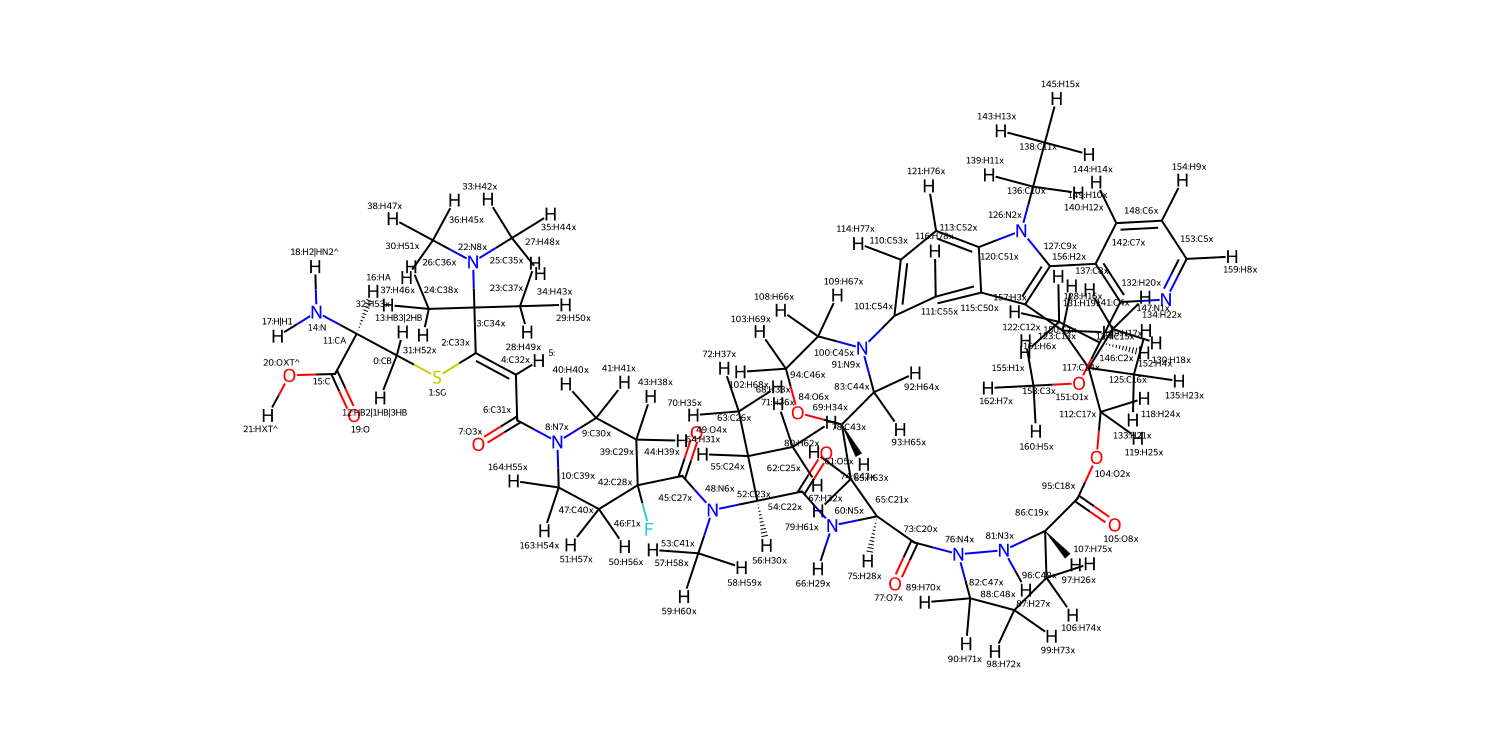

In [11]:
from ptm_prototype import react_mod

products = list(react_mod([cysteine, Elironrasib], covalent_triple_bond_smarts_cis))
adduct = products[0][0]

draw_molecule(
    adduct,
    width=1500,
    height=750,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(adduct.atoms)
    },
)

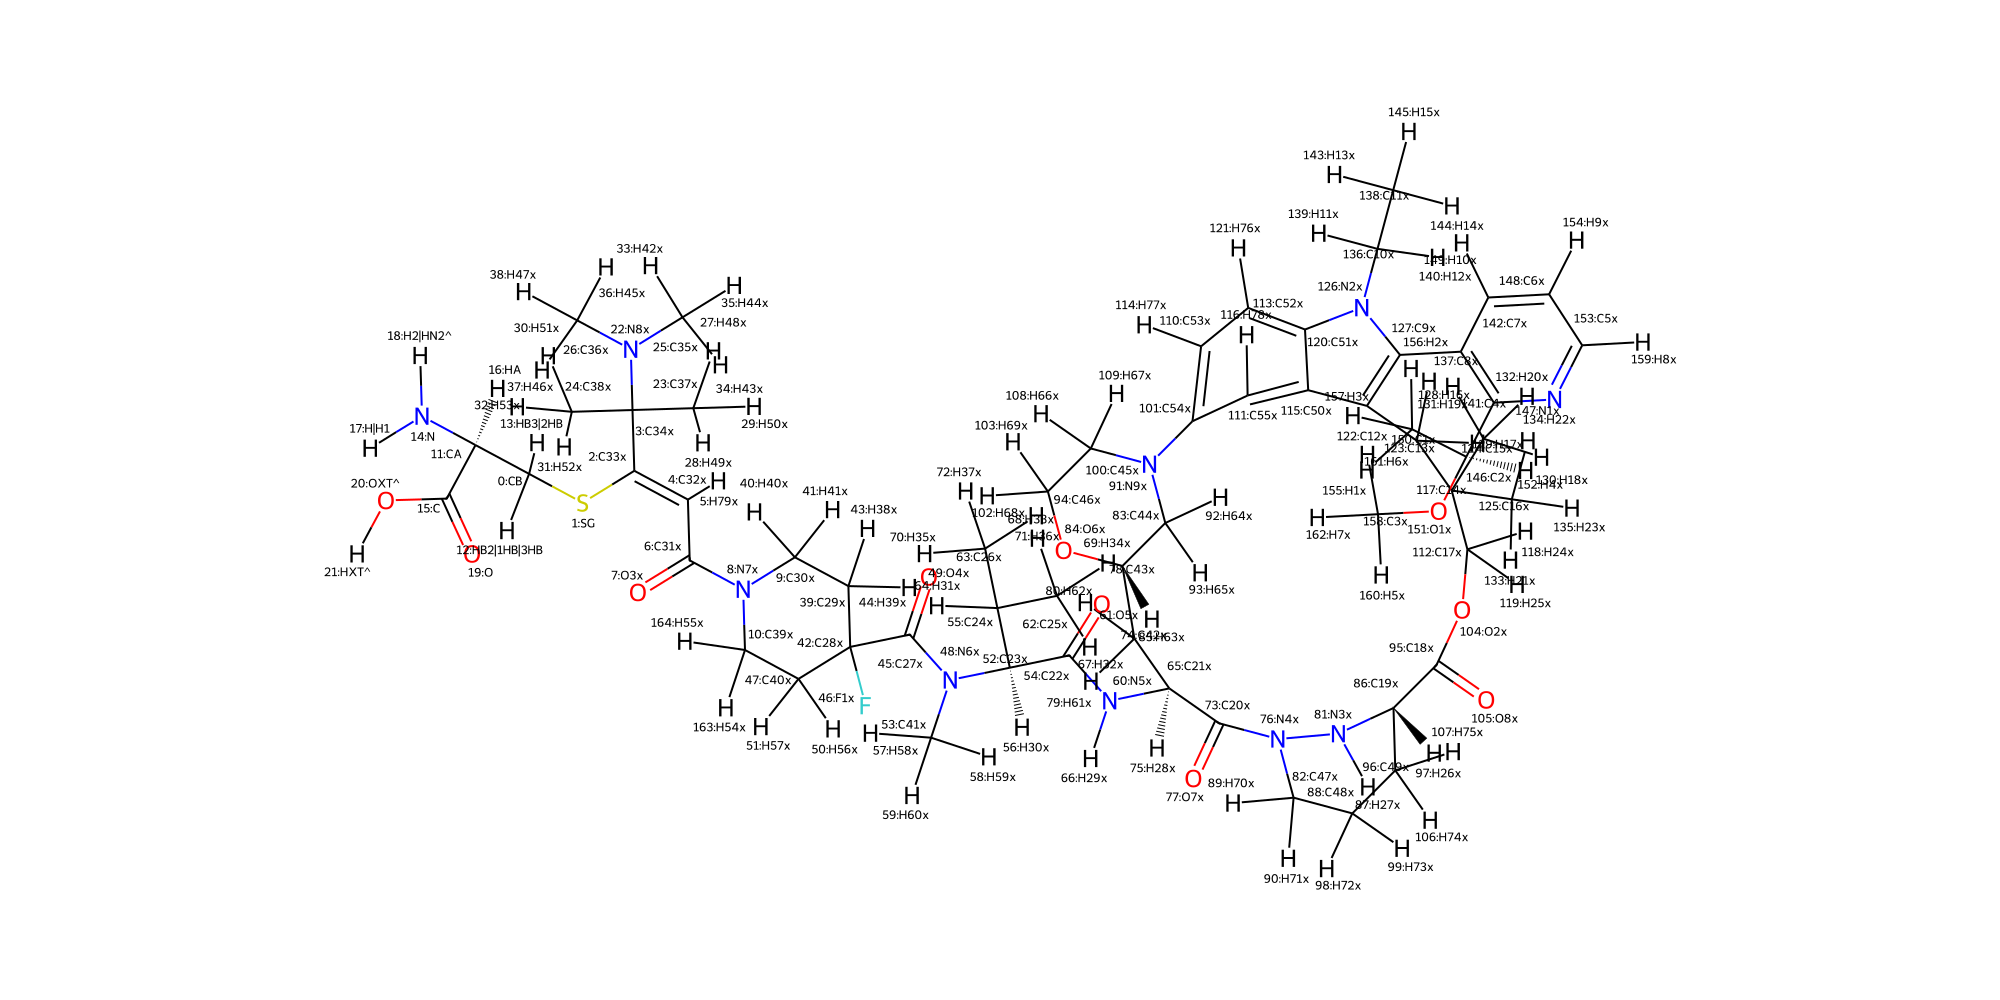

In [12]:
adduct.atom(5).name = 'H79x'

draw_molecule(
    adduct,
    width=2000,
    height=1000,
    atom_notes={
        i: (
            f"{i}:{'|'.join([atom.name, *atom.metadata.get('synonyms', '').split()])}"
            + f"{'^' if bool(atom.metadata.get('leaving_atom')) else ''}"
        )
        for i, atom in enumerate(adduct.atoms)
    },
)

In [ ]:
ligand_resdef = ResidueDefinition.from_molecule(
    molecule=adduct,
    residue_name="LIG",
    linking_bond=PEPTIDE_BOND,
)
#substructure_mol = ligand_resdef.to_openff_molecule()

In [14]:
suppl = Chem.SDMolSupplier('CYSLIG_clean.sdf')[0]
suppl_H = Chem.AddHs(suppl, addCoords=True)
Elironrasib_ref_H_canonical_smiles = Chem.MolToSmiles(suppl_H, canonical=True)
print(Elironrasib_ref_H_canonical_smiles)
#
adduct_mol_H = adduct.to_rdkit()
Elironrasib_top_H_canonical_smiles = Chem.MolToSmiles(adduct_mol_H, canonical=True)
print(Elironrasib_top_H_canonical_smiles)

[H]OC(=O)[C@@]([H])(N([H])[H])C([H])([H])S/C(=C(/[H])C(=O)N1C([H])([H])C([H])([H])C(F)(C(=O)N(C([H])([H])[H])[C@]([H])(C(=O)N([H])[C@]2([H])C(=O)N3N([H])[C@]([H])(C(=O)OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])c4c(-c5c([C@@]([H])(OC([H])([H])[H])C([H])([H])[H])nc([H])c([H])c5[H])n(C([H])([H])C([H])([H])[H])c5c([H])c([H])c(c([H])c45)N4C([H])([H])C([H])([H])O[C@]([H])(C4([H])[H])C2([H])[H])C([H])([H])C([H])([H])C3([H])[H])C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H])C(N(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H]
[H]OC(=O)[C@@]([H])(N([H])[H])C([H])([H])S/C(=C(/[H])C(=O)N1C([H])([H])C([H])([H])C(F)(C(=O)N(C([H])([H])[H])[C@]([H])(C(=O)N([H])[C@]2([H])C(=O)N3N([H])[C@]([H])(C(=O)OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])C4=C(c5c([C@@]([H])(OC([H])([H])[H])C([H])([H])[H])nc([H])c([H])c5[H])N(C([H])([H])C([H])([H])[H])c5c([H])c([H])c(c([H])c54)N4C([H])([H])C([H])([H])O[C@]([H])(C4([H])[H])C2([H])[H])C([H])([H])C([H])([H])C3([H])[H])

In [15]:
list_1 = list(map(int, adduct_mol_H.GetProp("_smilesAtomOutputOrder")[1:-1].split(",")))
list_2 = list(map(int, suppl_H.GetProp("_smilesAtomOutputOrder")[1:-1].split(",")))
if Elironrasib_top_H_canonical_smiles == Elironrasib_ref_H_canonical_smiles:
    print(True)
    res = list(zip(list_2,list_1))
    res.sort(key=lambda x: x[1])
    unzipped_list_2, unzipped_list_1 = zip(*res)
    new_indices = list(unzipped_list_2)
#
suppl_r = Chem.RenumberAtoms(suppl_H, new_indices)
IPython.display.display(Chem.Draw.MolToImage(suppl_r, size=(1000, 500), options=draw_options))

NameError: name 'new_indices' is not defined

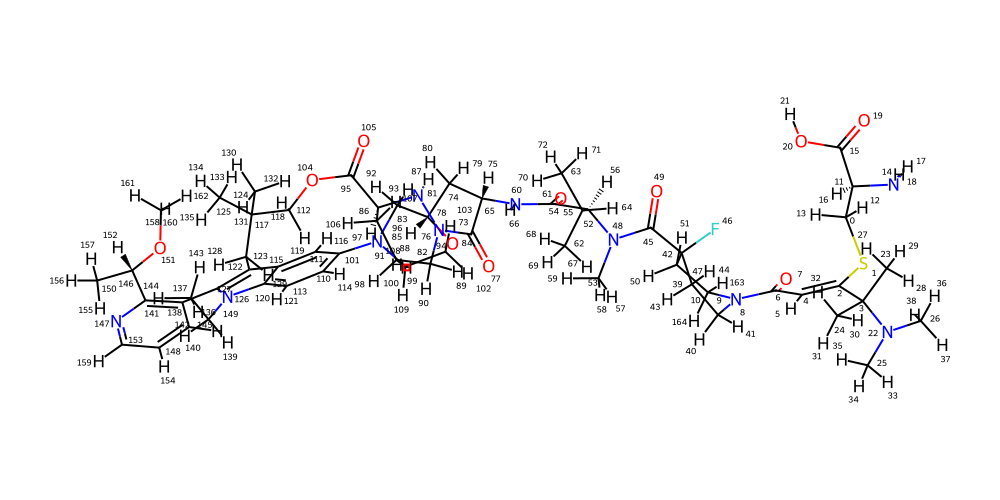

In [16]:
IPython.display.display(Chem.Draw.MolToImage(adduct_mol_H, size=(1000, 500), options=draw_options))

In [17]:
for i, atom in enumerate(adduct_mol_H.GetAtoms()):
    info = AtomPDBResidueInfo(
        atom.GetProp('_Name'),
        atom.GetIdx() + 1,
        ' ',
        'LIG',
        12,
        'B',
        ' ',
    )    
    suppl_r.GetAtomWithIdx(i).SetMonomerInfo(info)
Chem.MolToPDBFile(suppl_r, 'CYSLIG_clean_renamed.pdb')

NameError: name 'suppl_r' is not defined

use openmm-setup in conda env openfe_env

In [29]:
from openff.pablo import CCD_RESIDUE_DEFINITION_CACHE, topology_from_pdb

topology = topology_from_pdb(
    "test_2.pdb",
    residue_database=CCD_RESIDUE_DEFINITION_CACHE.with_({"LIG": [ligand_resdef]}),
)

In [30]:
topology.to_file('test_top.pdb')

In [37]:
topology.box_vectors=None

In [40]:
topology

In [71]:
import openmm.unit as unit
from openff.toolkit import Molecule, ForceField
from openff.interchange import Interchange
from openff.interchange.components._packmol import (
    RHOMBIC_DODECAHEDRON,
    solvate_topology,
)

solvated_topology = solvate_topology(
    topology,
    nacl_conc=Quantity(0.15, "mol/L"),
    padding=Quantity(1.0, "nm"),
    box_shape=RHOMBIC_DODECAHEDRON,
)

In [75]:
from ptm_prototype import parametrize_with_nagl
sage_ff14sb = ForceField("openff-2.2.1.offxml", "ff14sb_off_impropers_0.0.4.offxml", )
interchange = parametrize_with_nagl(force_field=sage_ff14sb, topology=solvated_topology)
view = interchange.visualize()
view.clear_representations()
view.add_representation("ball+stick", selection="all")
view

adding dummy charges to force field ...
making Interchange ...
replacing dummy charges with NAGL charges ... 
assigning graph charges to C907H1425FN242O279S5 ...


[21:07:13] WARNING: Proton(s) added/removed



continuing with dummy charge replacement ...


NGLWidget()

In [87]:
interchange.to_top("test_2.top")
interchange.to_gro("test_2.gro")

ValidationError: 1 validation error for GROMACSAtom
residue_index
  Input should be greater than 0 [type=greater_than, input_value='0', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/greater_than

In [77]:
import openmm
from ptm_prototype import get_openmm_total_charge

temperature = 300 * openmm.unit.kelvin
pressure = 1 * openmm.unit.bar

timestep = 2 * openmm.unit.femtosecond
friction_coeff = 1 / openmm.unit.picosecond
barostat_frequency = 25

simulation = interchange.to_openmm_simulation(
    integrator=openmm.LangevinMiddleIntegrator(
        temperature,
        friction_coeff,
        timestep,
    ),
    additional_forces=[
        openmm.MonteCarloBarostat(
            pressure,
            temperature,
            barostat_frequency,
        ),
    ],
)
#
print(f"total system charge is {get_openmm_total_charge(simulation.system)}")
#
with open("test_2_system.xml", "w") as f:
    f.write(openmm.XmlSerializer.serialize(simulation.system))

total system charge is -1.0591421606420681e-07


In [78]:
from openmm.app import PDBFile
with open('test_2_initial_system.pdb', 'w') as f:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(), f)

In [79]:
context = simulation.context
print("Simulation is running on:", context.getPlatform().getName())

Simulation is running on: CUDA


Minimize the energy:

In [80]:
simulation.context.computeVirtualSites()
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(simulation.integrator.getTemperature())

In [81]:
dcd_reporter = app.DCDReporter('test_2_trajectory.dcd', 100)
simulation.reporters.append(dcd_reporter)
#
state_reporter = app.StateDataReporter('test_2_energy_data.csv',
                                       100,
                                       step=True,
                                       time=True, 
                                       potentialEnergy=True,
                                       kineticEnergy=True,
                                       totalEnergy=True,
                                       temperature=True,
                                       volume=True,
                                       density=True,
                                       speed=True,
                                      )
simulation.reporters.append(state_reporter)

Run the simulation for a minute of wall time:

In [82]:
simulation.runForClockTime(10 * openmm.unit.minute)

Finally, visualize the resulting trajectory in NGLView!

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


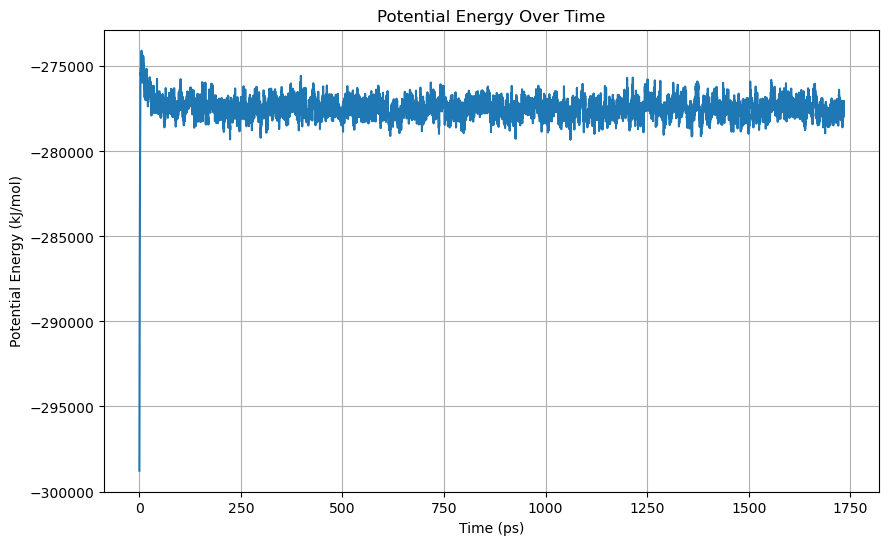

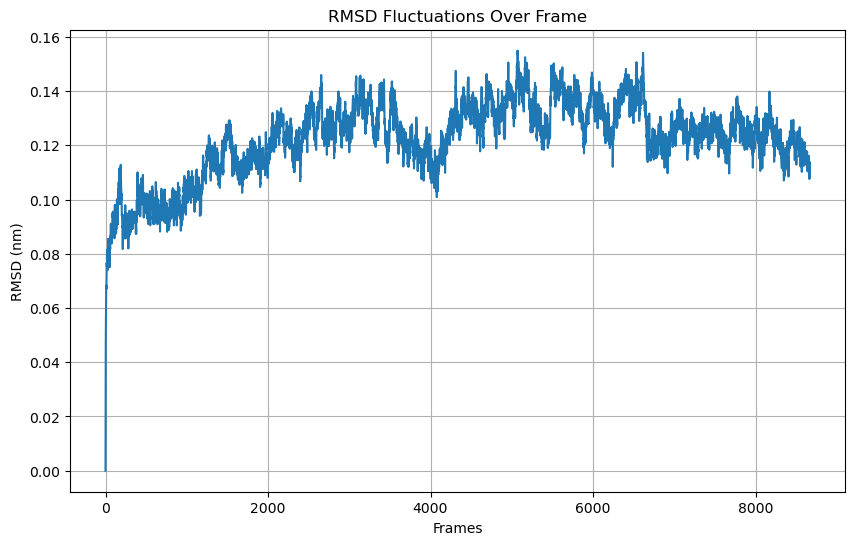

In [84]:
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#
topology_file = 'test_2_initial_system.pdb'
trajectory_file = 'test_2_trajectory.dcd'
traj = md.load(trajectory_file, top=topology_file)
#
state_file = 'test_2_energy_data.csv'
#
def plot_potential_energy(state_file):

    df = pd.read_csv(state_file)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='Time (ps)', y='Potential Energy (kJ/mole)')
    plt.xlabel('Time (ps)')
    plt.ylabel('Potential Energy (kJ/mol)')
    plt.title('Potential Energy Over Time')
    plt.grid(True)
    plt.show()


def plot_rmsd_fluctuations(traj):

    traj.image_molecules(inplace=True)
    ca_atoms = traj.topology.select('protein and name CA')
    traj.superpose(traj, frame=0, atom_indices=ca_atoms)
    rmsd = md.rmsd(traj, traj, 0, atom_indices=ca_atoms)
    frames = np.arange(0, traj.n_frames)
    traj.save('test_2_processed_trajectory.xtc') 
    plt.figure(figsize=(10, 6))
    plt.plot(frames, rmsd, label='RMSD')
    plt.xlabel('Frames')
    plt.ylabel('RMSD (nm)')
    plt.title('RMSD Fluctuations Over Frame')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    plot_potential_energy(state_file)
    plot_rmsd_fluctuations(traj)